# このnotebookについて


# 事前準備

In [ ]:
import os
import json

import numpy as np
import pandas as pd


In [ ]:
# 自作モジュールの読み込み
from modules.file_format.HDF5 import HDF5Reader, HDF5Writer
from modules.app_utils.setting_handler import RunListMaster
from modules.file_format.spe_wrapper import SpeWrapper


In [ ]:
"""pathの設定"""
import sys
repository_root = None
for sys_path in sys.path:
    if sys_path.endswith('LAMBDA-Melting'):
        repository_root = sys_path
if repository_root is None:
    raise ValueError('repository_root is not set')

"""plot用の設定"""
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'     #数式用のフォントejavuserif" or "cm"
plt.rcParams['xtick.direction'] = 'in'      #x軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'      #y軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0     #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0     #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 14               #フォントの大きさ
plt.rcParams['axes.linewidth'] = 0.8        #軸の線幅edge linewidth。囲みの太さ
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 6)
# Arialフォントを設定
plt.rcParams.update({
    "font.family": "Arial",           # フォントをArialに設定
    "mathtext.fontset": "custom",     # カスタムフォントを指定
    "mathtext.rm": "Arial",           # 数式の通常テキスト部分
    "mathtext.it": "Arial",    # 数式のイタリック部分
    "mathtext.bf": "Arial"       # 数式の太字部分
})

# 読み込み先の設定

## 選んだRunを読み込み

In [ ]:
# runの読み込み
# Run Selectorで選択したことを想定する
path_to_run_setting = os.path.join(repository_root, 'settings', 'run_selector.json')
with open(path_to_run_setting) as json_file:
    selected_run_setting = json.load(json_file)

In [ ]:
selected_run_setting

## 温度データを読み込み

In [ ]:
path_to_dist = os.path.join(
    selected_run_setting['path_to_run_files'],
    selected_run_setting['selected_files']['Temperature']['dist']
)
dist_hdf = HDF5Reader(path_to_dist)

In [ ]:
spe = SpeWrapper(os.path.join(
    selected_run_setting['path_to_run_files'],
    selected_run_setting['selected_files']['Temperature']['raw_radiation']
))
spe.get_params_from_xml()
spe.framerate

## 配列を作成する処理

In [ ]:
dist_hdf.path_list

In [ ]:
# 温度mapとradiation強度を読み込む
dist_array = dist_hdf.find_by(query='value/T')
dist_array[dist_array > 10_000] = 0 # ここで変な値は切っておく

T_error_array = dist_hdf.find_by(query='error/T')

radiation_array = dist_hdf.find_by(query='spe/2d_max_intensity')

In [ ]:
# 温度データの形状を取得しておく
frame_num, position_num = dist_array.shape
# 配列を作っておく
frame_array = np.arange(frame_num)
frame_num, position_num

In [ ]:
# 視覚化
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
im1 = axes[0].imshow(dist_array.T, cmap='seismic')
axes[0].set_title("Dist Array")
fig.colorbar(im1, ax=axes[0], orientation='vertical')  # カラーバーの追加
im2 = axes[1].imshow(radiation_array.T, cmap='seismic')
axes[1].set_title("Radiation Array")
fig.colorbar(im2, ax=axes[1], orientation='vertical')  # カラーバーの追加
plt.tight_layout()  # レイアウトを調整
plt.show()

In [ ]:
# 採用するstreamを選択 (up or down)
adopted_stream = 'down'

# 最大位置を調べる
match adopted_stream:
    case 'up':
        max_position_arr = np.argmax(radiation_array[:, :round(position_num/2)], axis=1)
    case 'down':
        max_position_arr = np.argmax(radiation_array[:, round(position_num/2):], axis=1) + round(position_num/2)

In [ ]:
# 露光強度をもとにした採用温度点
plt.figure(figsize=(8, 4))
plt.imshow(dist_array.T, cmap='gray')
plt.colorbar()
plt.scatter(frame_array, max_position_arr, c='red', s=0.1)
plt.title(f'Adopted temperature of {selected_run_setting['current_run']}')
plt.show()
plt.close()


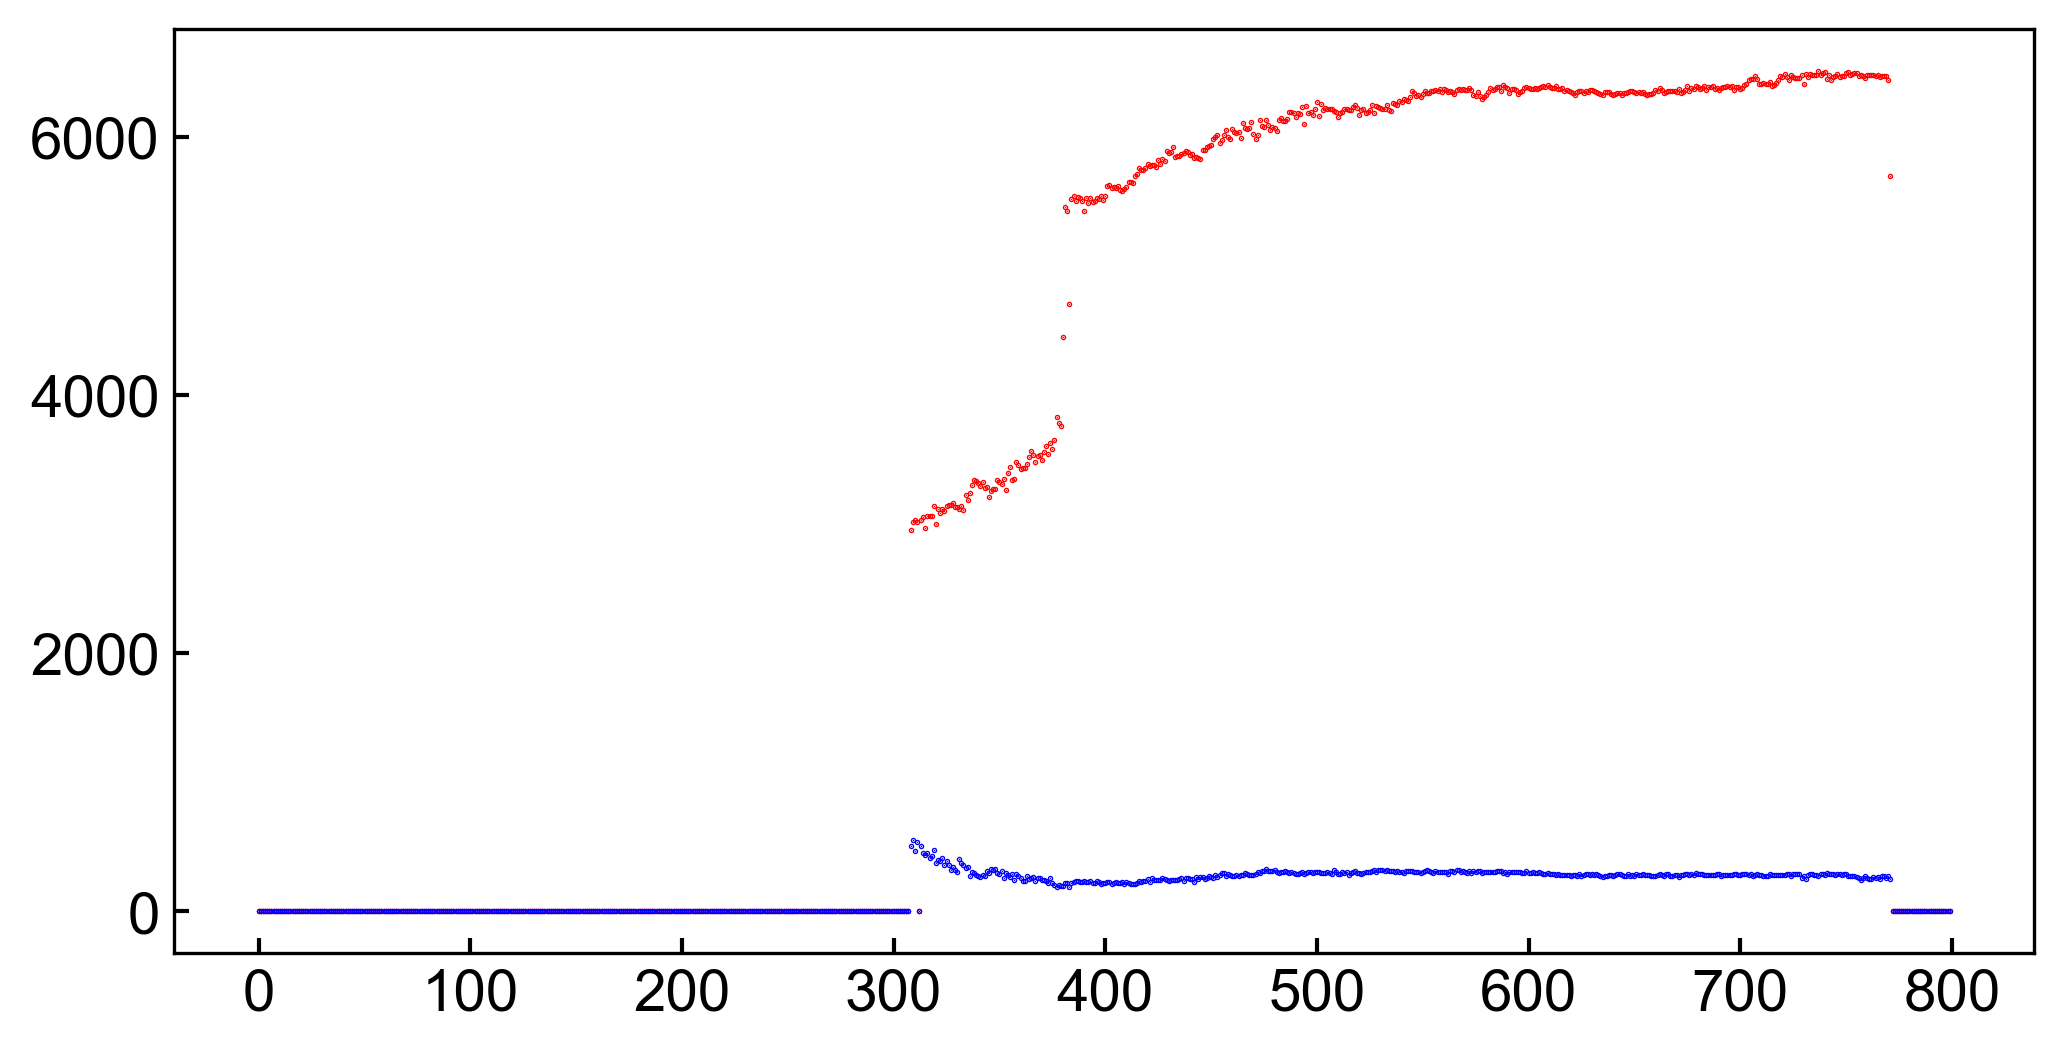

In [23]:
# 各フレームの最大位置に対応する温度値を取得
measured_T_array = dist_array[frame_array, max_position_arr]
# エラーも
measured_error_array = T_error_array[frame_array, max_position_arr] * 14

plt.figure(figsize=(8, 4))
plt.scatter(frame_array, measured_T_array, c='red', s=0.1)
plt.scatter(frame_array, measured_error_array, c='blue', s=0.1)
plt.show()
plt.close()

# 書き込み先の設定

In [ ]:
# 上書きするかどうかを設定
is_overwritten = selected_run_setting['is_overwritten']
is_overwritten

In [24]:
# 採用したstreamを保存
master = RunListMaster()
master.use_from_notebook(repository_root=repository_root)
if is_overwritten:
    master.update_adopt_side(run_name=selected_run_setting['current_run'], new_adopted_steram=adopted_stream)
    master.save_to_excel()

File ref_data/run_list.xlsx not found.
/Users/ishizawaosamu/work/MasterThesis/LAMBDA-Melting/ref_data/run_list.xlsx にパスが変更され、Excelファイルが読み込まれました。
Excelファイルの更新成功


In [ ]:
# HDF
# run_name_processed.hdfを作成する
saved_hdf = HDF5Writer(
    file_path=os.path.join(
        selected_run_setting['save_root_path'],
        'processed_hdf',
        f'{selected_run_setting["current_run"]}_processed.hdf5'
    )
)